In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pystan
import pickle
%matplotlib inline
import vincent
from IPython.display import display

In [2]:
pd.set_option('display.max_columns', 50)

In [3]:
# This is a dictionary which allows us to map state abbreviations to full names
import us
state_map = us.states.mapping('abbr', 'name')

Here we read in the historical tornado data as a pandas dataframe.  The description of all the columns can be found here ... 

In [4]:
names = ('Tornado Number','Year','Month','Day','Date','Time','Time Zone','State','State ID','State Number',\
         'Scale','Injuries','Fatalities','Property Loss','Crop Loss','Starting Lat','Starting Lon',\
         'Ending Lat','Ending Lon','Length','Width','Number of States','State Flag','Segment Number',\
         '1st County','2nd County','3rd County','4th County','Wind')

data = pd.read_csv('1950-2014_torn.csv',names=names)
data = data.query('Year >= 1955')

In [5]:
states = data['State'].unique()
years = data['Year'].unique()
state_IDs = data['State ID'].unique()

# Here we create various dictionaries which maps a string to it's index in the array
state_dict = {}
for i,state in enumerate(states):
    state_dict[states[i]]=i
state_ID_dict = {}
for i,ID in enumerate(state_IDs):
    state_ID_dict[ID]=i

#Here we group the years by decade, which reduces the number of dimensions of our problem by a factor of 10,
#Allowing for faster computation and larger number statistics
year_dict = {}
j=0
for i,year in enumerate(years):
    year_dict[year]=j
    if i%10==9:
        j+=1

#We combine the FIPS state ID and FIPS county ID into one string, which can then be read into the map
counties = np.array(list(set([str(x).zfill(2)+str(y).zfill(3) for x,y in zip(data['State ID'].values,data['1st County'].values) if y!=0]+\
    [str(x).zfill(2)+str(y).zfill(3) for x,y in zip(data['State ID'].values,data['2nd County'].values) if y!=0]+\
    [str(x).zfill(2)+str(y).zfill(3) for x,y in zip(data['State ID'].values,data['3rd County'].values) if y!=0]+\
    [str(x).zfill(2)+str(y).zfill(3) for x,y in zip(data['State ID'].values,data['4th County'].values) if y!=0])))

county_dict = {}
for i,k in enumerate(counties):
    county_dict[k]=i

We also group the Tornado f-scales into 3 groups of 0&1, 2&3, and 4&5.  Again, to reduce the dimensions of our system.

While the full database has information about the full track of the tornado across each county, we felt like using this information would give a bias to small counties (particularly since we are already taking land mass into account in the model).  That is, one tornado can cross multiple small counties in it's path, but only is counted once for a large county.  So, instead, we only look at the county where the tornado acutally touched down.

In [6]:
#Here I create an array split with dimensions of counties, years, and f-scale groups.
t_data_full = np.zeros((len(counties),len(np.unique(year_dict.values())),3),dtype=int)
for i in data.index:
    row = data.ix[i]
    scale = row['Scale']
    if row['State Flag'] ==1 and scale>=0:
        if row['1st County']!=0:
            if scale ==0 or scale==1:
                t_data_full[county_dict[str(row['State ID']).zfill(2)+str(row['1st County']).zfill(3)]][year_dict[row['Year']]][0]+=1
            if scale ==2 or scale==3:
                t_data_full[county_dict[str(row['State ID']).zfill(2)+str(row['1st County']).zfill(3)]][year_dict[row['Year']]][1]+=1
            if scale ==4 or scale==5 or scale >5:
                t_data_full[county_dict[str(row['State ID']).zfill(2)+str(row['1st County']).zfill(3)]][year_dict[row['Year']]][2]+=1


For the full United States, our model takes a significant amount of time to run (roughly 2 hours per 100 iterations).  So I choose 7 states for the time being which fall in tornado alley, allowing us to run the full model with a substantial amount of iterations and multiple chains to test for convergence.

In [7]:
county_land_mass_df = pd.read_csv('County_land_mass.csv')
states_used = ['CO','NE','KS','OK','IA','MO','AR']
#states_used=[st for st in states if st not in ['DC']]  #DC being both a county and state could mess up our model

county_state_list = []
used_inds = []
#Here we eliminate states we don't want to use, listed above, counties which don't have land mass information,
#and the small unincorporated city-counties of VA, which have an extremely small land mass and thus screw our 
#tornados/sq. km. metric.
for i in range(len(counties)):
    if states[state_ID_dict[int(counties[i][0:2])]] in states_used and int(counties[i]) in county_land_mass_df['STCOU'].values\
        and (int(counties[i])<51500 or int(counties[i])>=52000):
        used_inds.append(i)
        county_state_list.append(state_ID_dict[int(counties[i][0:2])])
t_data = t_data_full[used_inds]
county_state_list = np.array(county_state_list)

#This is a map of the index of the counties to an index of what state it's in.
county_state_map = np.zeros_like(county_state_list)
for i,st in enumerate(county_state_list):
    county_state_map[i] = np.where(st==np.unique(county_state_list))[0]

#This maps the county index to its respective land mass
county_land_mass = np.zeros(len(used_inds))
for i,ct in enumerate(counties[used_inds]):
    county_land_mass[i] = county_land_mass_df[county_land_mass_df['STCOU'] == int(ct)]['Land_mass'].values[0]

Here we have a directed acyclic graphical representation of our model.  We model the number of tornados, for any given county, year, or f-scale, as a poisson distribution, whose log rate parameter is dependent on a linear combination of various factors.  We take the log land mass, since adding this linearly into the log rate parameter essentially makes it a multiplicative factor

In [ ]:
$$ y \sim \mathrm{normal}(e^{\beta_{\textrm{county}}+\beta_{\textrm{county}}+\beta_{\textrm{county}}}) $$

We have a year_factor, which depends on what year the tornado occurs in.  This will help us look for trends in time, as well as remove some of the year-to-year variability of weather patterns.  We have a county_factor, which depends on the county the tornado occurs in.  The county-factor is furthermore drawn from a normal distribution with hyperparameters dependent on which state the county is located in.  We set the priors of these hyperparaters to be weakly informative normals for location-type parameters and half-cauchy for scale type paramaters (see Gelman et. al. 2008).  We finally add a noise term for each observation which is normally distributed around 0 and allows for overdispersion of our generalized poisson model.

Here is our STAN code which implements the model.  

In [8]:
tornado_code = """
data {
    int<lower=0> N_obs; // Number of observations
    int<lower=0> N_yr; // Number of years
    int<lower=0> N_st; // Number of states
    int<lower=0> N_ct; // Number of counties
    int<lower=0> N_sc; // Number of f-scales
    real land_mass[N_ct]; // Land mass of counties
    int<lower=0> y[N_obs]; // Tornado number
    int<lower=0> county_state[N_ct]; // State in which county is in
}
parameters {
  //  real land_mass_factor;
  
    vector[N_sc*N_ct] county_factor;
    vector[N_sc*N_st] county_mu;
    vector<lower=0>[N_sc*N_st] county_sig;
    
    vector[N_sc*N_yr] year_factor;
    vector<lower=0>[N_sc] year_sig;

    vector[N_obs] noise_factor;
    vector<lower=0>[N_sc] noise_sig;
 
}
transformed parameters {
    //vector[N_obs] lambda;
    vector[N_obs] lambda;
    for (i in 1:N_ct) {
        for (j in 1:N_yr) {
            for (f in 1:N_sc) {
                lambda[(i-1)*N_yr*N_sc + (j-1)*N_sc + f] <- exp(
                year_factor[(j-1)*N_sc + f] + county_factor[(i-1)*N_sc + f] + log(land_mass[i]/100.0)
                + noise_factor[(i-1)*N_yr*N_sc + (j-1)*N_sc + f]) ;
            }
        }
    }
}
model  {
    county_mu ~ normal(0,10);
    county_sig ~ cauchy(0,2.5);
    for (i in 1:N_ct) {
        for (f in 1:N_sc) {
            county_factor[(i-1)*N_sc + f] ~ 
            normal(county_mu[(county_state[i]-1)*N_sc + f],county_sig[(county_state[i]-1)*N_sc + f]);
        }
    }
    year_sig ~ cauchy(0,2.5);
    for (j in 1:N_yr) {
        for (f in 1:N_sc) {
            year_factor[(j-1)*N_sc + f] ~ normal(0,year_sig[f]);
        }
    }
    noise_sig ~ cauchy(0,2.5);
    for (i in 1:N_ct) {
        for (j in 1:N_yr) {
            for (f in 1:N_sc) {
                noise_factor[(i-1)*N_yr*N_sc + (j-1)*N_sc + f] ~ normal(0,noise_sig[f]);
            }
        }
    }
    y ~ poisson(lambda);

}
"""

In [311]:
tornado_code = """
data {
    int<lower=0> N_obs; // Number of observations
    int<lower=0> N_yr; // Number of years
    int<lower=0> N_st; // Number of states
    int<lower=0> N_ct; // Number of counties
    int<lower=0> N_sc; // Number of f-scales
    real land_mass[N_ct]; // Land mass of counties
    int<lower=0> y[N_obs]; // Tornado number
    int<lower=0> county_state[N_ct]; // State in which county is in
    real county_sig[N_sc];
}
parameters {
  //  real land_mass_factor;
  
    vector[N_sc*N_ct] county_factor;
    vector[N_sc*N_st] county_mu;
 //   vector<lower=0>[N_sc*N_st] county_sig;
 //   vector<lower=0>[N_sc] county_sig_mu;
    
    vector[N_sc*N_yr] year_factor;
    vector<lower=0>[N_sc] year_sig;

    vector[N_obs] noise_factor;
    vector<lower=0>[N_sc] noise_sig;
 
}
transformed parameters {
    //vector[N_obs] lambda;
    vector[N_obs] lambda;
    for (i in 1:N_ct) {
        for (j in 1:N_yr) {
            for (f in 1:N_sc) {
                lambda[(i-1)*N_yr*N_sc + (j-1)*N_sc + f] <- exp(
                year_factor[(j-1)*N_sc + f] + county_factor[(i-1)*N_sc + f] + log(land_mass[i]/100.0)
                + noise_factor[(i-1)*N_yr*N_sc + (j-1)*N_sc + f]) ;
            }
        }
    }
}
model  {
 //   county_mu ~ normal(0,5);
  //  for (i in 1:N_st) {
   //     for (f in 1:N_sc) {
   //         county_sig[(county_state[i]-1)*N_sc + f] ~ cauchy(county_sig_mu[f],0.01);
    //    }
   // }
   
    for (i in 1:N_ct) {
        for (f in 1:N_sc) {
            county_factor[(i-1)*N_sc + f] ~ 
         //   normal(county_mu[(county_state[i]-1)*N_sc + f],county_sig[(county_state[i]-1)*N_sc + f]);
            normal(county_mu[(county_state[i]-1)*N_sc + f],county_sig[f]);
        }
    }
    year_sig ~ cauchy(0,0.1);
    for (j in 1:N_yr) {
        for (f in 1:N_sc) {
            year_factor[(j-1)*N_sc + f] ~ normal(0,year_sig[f]);
        }
    }
    noise_sig ~ cauchy(0,0.1);
    for (i in 1:N_ct) {
        for (j in 1:N_yr) {
            for (f in 1:N_sc) {
                noise_factor[(i-1)*N_yr*N_sc + (j-1)*N_sc + f] ~ normal(0,noise_sig[f]);
            }
        }
    }
    y ~ poisson(lambda);

}
"""

Here we specify the data which is input into the STAN model

In [9]:
tornado_dat = {'N_obs':t_data.shape[0]*t_data.shape[1]*t_data.shape[2],
                'N_yr':t_data.shape[1],
               'N_st':len(states_used),
               'N_ct':t_data.shape[0],
               'N_sc':t_data.shape[2],
               'land_mass':county_land_mass,
               'y':t_data.flatten(),
              'county_state':np.array(county_state_map+1,dtype=int),
              #'county_sig':[0.5,0.75,1.0]
              }

And finally we compile and compute the model.  STAN has an autmatic warmup, or burn-in, of half the number of iterations you specify.  We also run four chains simultaneously to test for convergence.

In [10]:
sm = pystan.StanModel(model_code=tornado_code)
fit = sm.sampling(data=tornado_dat,iter=2000,chains=4)

//anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
//anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
//anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
//anaconda/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
Wh

In [11]:
all_la = fit.extract(permuted=False,inc_warmup=True)

In [12]:
pickle.dump(all_la, open( "all_la_unpermuted.pickle", "wb" ) )

In [ ]:
c_mu = la[[i for i,f in enumerate(fit.flatnames) if str(f)[0:8] == 'county_m']].reshape(t['N_st'],t['N_sc'])

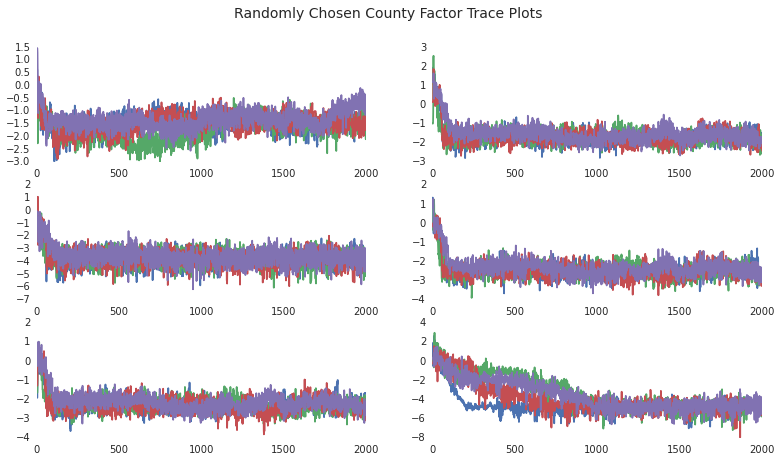

In [41]:
county_inds = [i for i,f in enumerate(fit.flatnames) if str(f)[0:8] == 'county_f']
plt.figure(figsize=(13,7))
j=0
for i in np.random.choice(county_inds,size=6):
    plt.subplot(3,2,j)
    plt.plot(all_la[:,0,i])
    plt.plot(all_la[:,1,i])
    plt.plot(all_la[:,2,i])
    plt.plot(all_la[:,3,i])
    j+=1
plt.suptitle('Randomly Chosen County Factor Trace Plots',size=14)
plt.show()

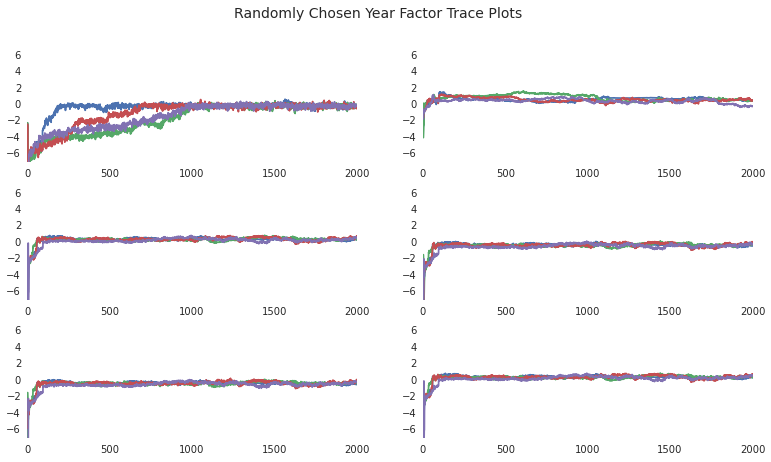

In [43]:
year_inds = [i for i,f in enumerate(fit.flatnames) if str(f)[0:6] == 'year_f']
plt.figure(figsize=(13,7))
j=0
for i in np.random.choice(year_inds,size=6):
    plt.subplot(3,2,j)
    plt.plot(all_la[:,0,i])
    plt.plot(all_la[:,1,i])
    plt.plot(all_la[:,2,i])
    plt.plot(all_la[:,3,i])
    plt.ylim(-7,7)
    j+=1
plt.suptitle('Randomly Chosen Year Factor Trace Plots',size=14)
plt.show()

We can see that both the county level and year level factors converge roughly after 1000 iterations, meaning our warm up of 1000 was well chosen.

In [44]:
la = fit.extract(permuted=True)

In [64]:
pickle.dump(la, open( "la_permuted.pickle", "wb" ) )

Here we'll also show the histograms for random counties and years.

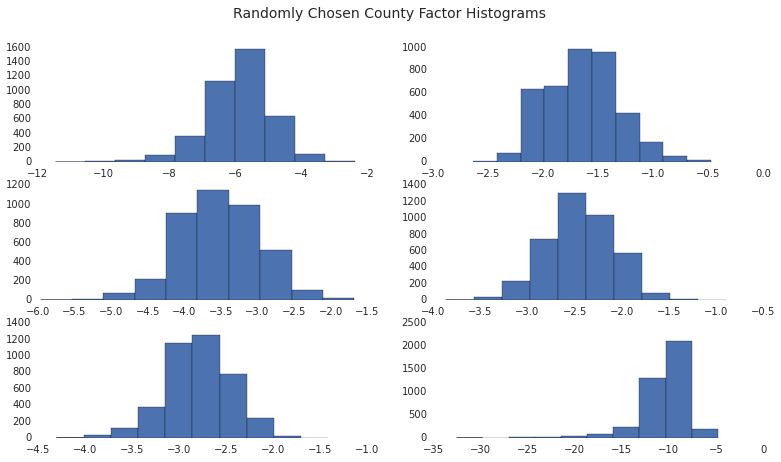

In [120]:
county_inds = [i for i,f in enumerate(fit.flatnames) if str(f)[0:8] == 'county_f']
plt.figure(figsize=(13,7))
j=0
for i in np.random.randint(0,la['county_factor'].shape[1],size=6):
    plt.subplot(3,2,j)
    plt.hist(la['county_factor'][:,i])
    j+=1
plt.suptitle('Randomly Chosen County Factor Histograms',size=14)
plt.show()

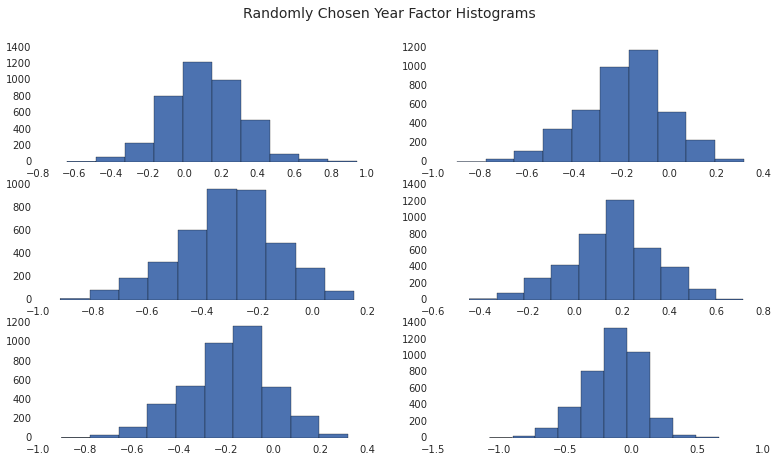

In [121]:
county_inds = [i for i,f in enumerate(fit.flatnames) if str(f)[0:8] == 'county_f']
plt.figure(figsize=(13,7))
j=0
for i in np.random.randint(0,la['year_factor'].shape[1],size=6):
    plt.subplot(3,2,j)
    plt.hist(la['year_factor'][:,i])
    j+=1
plt.suptitle('Randomly Chosen Year Factor Histograms',size=14)
plt.show()

Let's plot the year_factors consecutively to see if there are any trends with time.

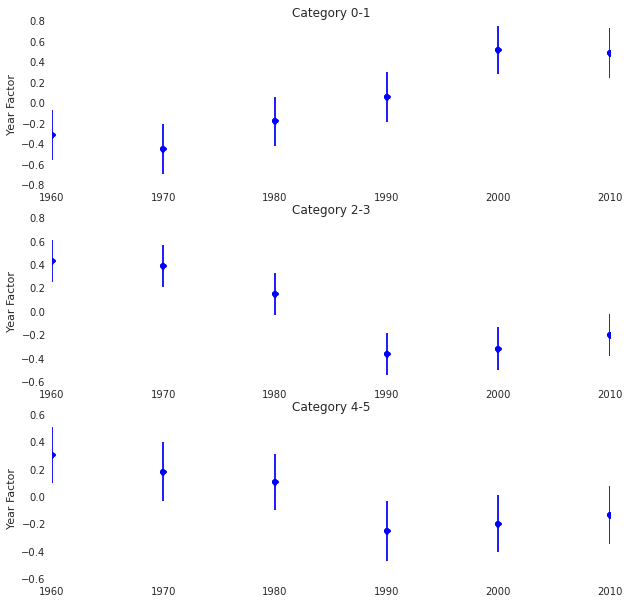

In [122]:
t = tornado_dat
la_year = la['year_factor'].reshape(4000,t['N_yr'],3)
fig = plt.figure(figsize=(10,10))
#plt.errorbar(years,np.mean(np.exp(la['year_factor']-la['year_factor'].mean()),axis=0),yerr=np.std(np.exp(la['year_factor']),axis=0),label='Bayesian Estimate')
decades = [1960,1970,1980,1990,2000,2010]
plt.subplot(3,1,1)
plt.errorbar(decades,np.mean(la_year[:,:,0],axis=0),yerr=np.std(la_year[:,:,0],axis=0),fmt='bo')
plt.title('Category 0-1')
plt.ylabel('Year Factor')
plt.subplot(3,1,2)
plt.errorbar(decades,np.mean(la_year[:,:,1],axis=0),yerr=np.std(la_year[:,:,1],axis=0),fmt='bo')
plt.title('Category 2-3')
plt.ylabel('Year Factor')
plt.subplot(3,1,3)
plt.errorbar(decades,np.mean(la_year[:,:,2],axis=0),yerr=np.std(la_year[:,:,2],axis=0),fmt='bo')
plt.title('Category 4-5')
plt.ylabel('Year Factor')
#plt.plot(years,np.exp(np.mean(la['year_factor']-la['year_factor'].mean(),axis=0)))
#plt.errorbar(years,yearly_means-t_mean,np.std(yearly_means),label='Annual Means')
#plt.legend()
plt.show()

It appears that the number of small tornados has increased over time while the number of large tornados has decreased.  This could very well be a reporting bias, however.  We have just gotten better at reporting the small tornados.

In [266]:
la = fit.extract(permuted=True)
pickle.dump(la, open( "la_permuted.pickle", "wb" ) )
la = fit.extract(permuted=False)
pickle.dump(la, open( "la.pickle", "wb" ) )
la = fit.extract(permuted=False,inc_warmup=True)
pickle.dump(la, open( "la_with_warmup.pickle", "wb" ) )

To predict the number of tornados for a specific county, we simply draw each of the linear parameter factors from it's respective county and year level posterior distributions.  To predict the number of tornados for a random county in a state, you would draw the hyperparameters from their posterior distribution, then draw a normal random number from these to account for the county_factor.

In [65]:
t = tornado_dat
ind = np.where(counties[used_inds]=='40015')[0][0]
caddo_tornados = []
for j in range(100):
    for i in range(100):
        county_factor = np.array(la['county_factor'][i]).reshape(t['N_ct'],t['N_sc'])[ind]
        year_factor = np.array(la['year_factor'][i]).reshape(t['N_yr'],t['N_sc'])[-1]
        noise_factor = np.array(la['noise_factor'][i]).reshape(t['N_ct'],t['N_yr'],t['N_sc'])[ind,-1]
        land_mass = county_land_mass[ind]
        caddo_tornados.append(np.random.poisson(np.exp(county_factor+year_factor+noise_factor)*land_mass/100.*1/10.))
caddo_tornados = np.array(caddo_tornados)

In [531]:
import seaborn as sns

In [536]:
sns.set_style('darkgrid')
sns.set_palette("deep", desat=.6)
#sns.set_context(rc={"figure.figsize": (8, 4)})

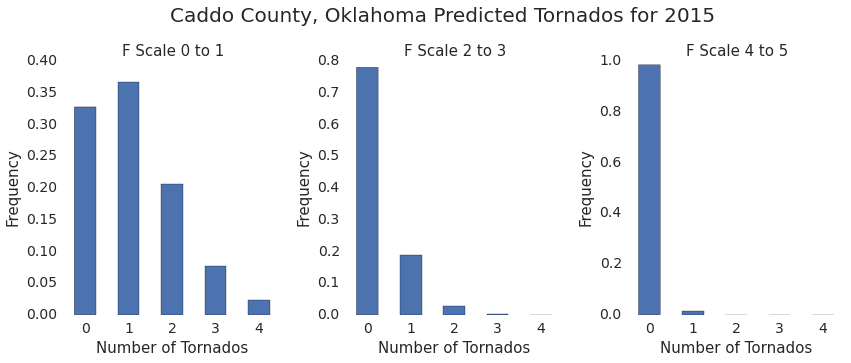

In [66]:
plt.figure(figsize=(14,5))
plt.subplots_adjust(wspace=0.3,top=0.83)
plt.subplot(1,3,1)
plt.hist(caddo_tornados[:,0],bins=[-0.5,0.5,1.5,2.5,3.5,4.5],rwidth=0.5,normed=True)
plt.xticks([0,1,2,3,4],size=14)
plt.yticks(size=14)
plt.xlim(-0.5,4.5)
plt.title('F Scale 0 to 1',size=15)
plt.xlabel('Number of Tornados',size=15)
plt.ylabel('Frequency',size=15)
plt.subplot(1,3,2)
plt.hist(caddo_tornados[:,1],bins=[-0.5,0.5,1.5,2.5,3.5,4.5],rwidth=0.5,normed=True)
plt.xlim(-0.5,4.5)
plt.xticks([0,1,2,3,4],size=14)
plt.yticks(size=14)
plt.title('F Scale 2 to 3',size=15)
plt.xlabel('Number of Tornados',size=15)
plt.ylabel('Frequency',size=15)
plt.subplot(1,3,3)
plt.hist(caddo_tornados[:,2],bins=[-0.5,0.5,1.5,2.5,3.5,4.5],rwidth=0.5,normed=True)
plt.xlim(-0.5,4.5)
plt.xticks([0,1,2,3,4],size=14)
plt.yticks(size=14)
plt.title('F Scale 4 to 5',size=15)
plt.xlabel('Number of Tornados',size=15)
plt.ylabel('Frequency',size=15)
plt.suptitle('Caddo County, Oklahoma Predicted Tornados for 2015',size=20)
plt.show()

Along these same lines, we can also perform predictive checks.  

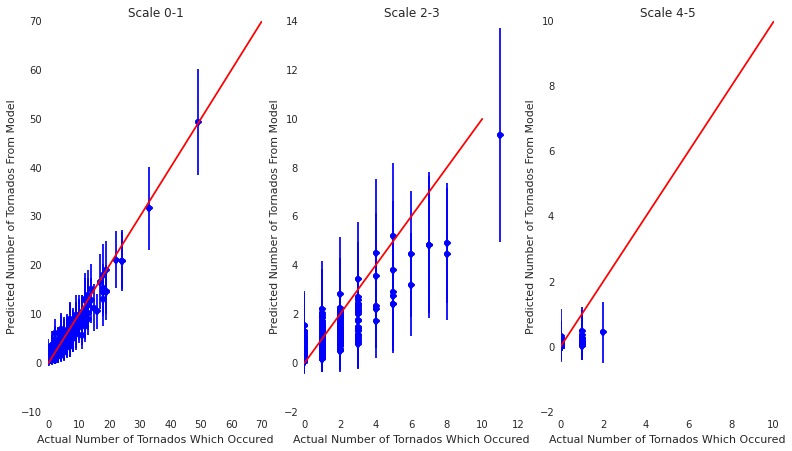

In [104]:
plt.figure(figsize=(13,7))
t = tornado_dat
N=500
plt.subplot(1,3,1)
scale=0
predicted_tornados=[[] for i in range(N)]
actual_tornados=np.zeros(N)
for j in range(N):
    county_ind = np.random.randint(0,t['N_ct'])
    year_ind = np.random.randint(0,t['N_yr'])
    for i in range(100):
        county_factor = np.array(la['county_factor'][i]).reshape(t['N_ct'],t['N_sc'])[county_ind,scale]
        year_factor = np.array(la['year_factor'][i]).reshape(t['N_yr'],t['N_sc'])[year_ind,scale]
        noise_factor = np.array(la['noise_factor'][i]).reshape(t['N_ct'],t['N_yr'],t['N_sc'])[county_ind,year_ind,scale]
        land_mass = county_land_mass[county_ind]
        predicted_tornados[j].append(np.random.poisson(np.exp(county_factor+year_factor+noise_factor)*land_mass/100.))
        actual_tornados[j] = t_data[county_ind,year_ind,scale]
tornados = np.array(tornados)

plt.errorbar(actual_tornados,np.mean(predicted_tornados,axis=1),yerr=np.std(predicted_tornados,axis=1),fmt='bo')
xs = np.linspace(0,70,1000)
plt.plot(xs,xs,'r-')
plt.xlabel('Actual Number of Tornados Which Occured')
plt.ylabel('Predicted Number of Tornados From Model')
plt.title('Scale 0-1')

plt.subplot(1,3,2)
scale=1
predicted_tornados=[[] for i in range(N)]
actual_tornados=np.zeros(N)
for j in range(N):
    county_ind = np.random.randint(0,t['N_ct'])
    year_ind = np.random.randint(0,t['N_yr'])
    for i in range(100):
        county_factor = np.array(la['county_factor'][i]).reshape(t['N_ct'],t['N_sc'])[county_ind,scale]
        year_factor = np.array(la['year_factor'][i]).reshape(t['N_yr'],t['N_sc'])[year_ind,scale]
        noise_factor = np.array(la['noise_factor'][i]).reshape(t['N_ct'],t['N_yr'],t['N_sc'])[county_ind,year_ind,scale]
        land_mass = county_land_mass[county_ind]
        predicted_tornados[j].append(np.random.poisson(np.exp(county_factor+year_factor+noise_factor)*land_mass/100.))
        actual_tornados[j] = t_data[county_ind,year_ind,scale]
tornados = np.array(tornados)

plt.errorbar(actual_tornados,np.mean(predicted_tornados,axis=1),yerr=np.std(predicted_tornados,axis=1),fmt='bo')
xs = np.linspace(0,10,1000)
plt.plot(xs,xs,'r-')
plt.xlabel('Actual Number of Tornados Which Occured')
plt.ylabel('Predicted Number of Tornados From Model')
plt.title('Scale 2-3')

plt.subplot(1,3,3)
scale=2
predicted_tornados=[[] for i in range(N)]
actual_tornados=np.zeros(N)
for j in range(N):
    county_ind = np.random.randint(0,t['N_ct'])
    year_ind = np.random.randint(0,t['N_yr'])
    for i in range(100):
        county_factor = np.array(la['county_factor'][i]).reshape(t['N_ct'],t['N_sc'])[county_ind,scale]
        year_factor = np.array(la['year_factor'][i]).reshape(t['N_yr'],t['N_sc'])[year_ind,scale]
        noise_factor = np.array(la['noise_factor'][i]).reshape(t['N_ct'],t['N_yr'],t['N_sc'])[county_ind,year_ind,scale]
        land_mass = county_land_mass[county_ind]
        predicted_tornados[j].append(np.random.poisson(np.exp(county_factor+year_factor+noise_factor)*land_mass/100.))
        actual_tornados[j] = t_data[county_ind,year_ind,scale]
tornados = np.array(tornados)

plt.errorbar(actual_tornados,np.mean(predicted_tornados,axis=1),yerr=np.std(predicted_tornados,axis=1),fmt='bo')
xs = np.linspace(0,10,1000)
plt.plot(xs,xs,'r-')
plt.xlabel('Actual Number of Tornados Which Occured')
plt.ylabel('Predicted Number of Tornados From Model')
plt.title('Scale 4-5')
plt.show()

You can see that the predicted number of tornados is regressed towards the mean (which would be the mean of whatever state the county occurs in).  This is a typical result of hierarchical and validates our model.

To display our maps, we use the plotting routine Vincent.

In [100]:
county_topo = r'us_counties.topo.json'
state_topo = r'us_states.topo.json'
geo_data = [ {'name': 'states',
             'url': state_topo,
             'feature': 'us_states.geo'},
           {'name': 'counties',
             'url': county_topo,
             'feature': 'us_counties.geo'},
    {'name': 'states',
             'url': state_topo,
             'feature': 'us_states.geo'}]

In [51]:
county_topo = r'us_counties.topo.json'
state_topo = r'us_states.topo.json'
geo_data = [
           {'name': 'counties',
             'url': county_topo,
             'feature': 'us_counties.geo'}
 ]

In [107]:
fit.get_posterior_mean()

AssertionError: 

In [108]:
#post_means = fit.get_posterior_mean()
t = tornado_dat
#county_means = np.exp(post_means[0:t['N_sc']*t['N_ct']].reshape((t['N_ct'],t['N_sc'])))
county_means = np.exp(np.array(la['county_factor']).reshape(la['county_factor'].shape[0],t['N_ct'],t['N_sc']).mean(axis=0))
#post_year_inds = [i for i,f in enumerate(fit.flatnames) if str(f)[0:6] == 'year_f']
#yrs = post_means[post_year_inds].reshape(t['N_yr'],t['N_sc'])
county_df_dict = {}
county_df_dict['NAME'] = []
county_df_dict['tornado0'] = []
county_df_dict['tornado1'] = []
county_df_dict['tornado2'] = []
for i,ct in enumerate(counties[used_inds]):
    state = county_state_map[i]
    county_df_dict['NAME'].append(ct)
    county_df_dict['tornado0'].append(county_means[i,0])
    county_df_dict['tornado1'].append(county_means[i,1])
    county_df_dict['tornado2'].append(county_means[i,2])
    #     county_df_dict['tornado'].append(np.exp(county_means[i][0]+state_factor[0]-np.mean(sorted_county_means[int(state)])))
    #county_df_dict['tornado'].append(t_data.mean(axis=1)[county_dict[ct]])
for i,ct in enumerate(county_land_mass_df.STCOU):
    #if ct == 4009:
    if ct not in np.array(county_df_dict['NAME'],dtype=int):
        county_df_dict['NAME'].append(str(ct).zfill(5))
        county_df_dict['tornado0'].append(np.min(county_means[:,0]))
        county_df_dict['tornado1'].append(np.min(county_means[:,1]))
        county_df_dict['tornado2'].append(np.min(county_means[:,2]))
county_df = pd.DataFrame(county_df_dict)
vis0 = vincent.Map(data=county_df, geo_data=geo_data, scale=1000,
                  projection='albersUsa', data_bind='tornado0', data_key='NAME',
                  map_key={'counties': 'properties.FIPS'}, brew='YlGnBu')
vis1 = vincent.Map(data=county_df, geo_data=geo_data, scale=1000,
                  projection='albersUsa', data_bind='tornado1', data_key='NAME',
                  map_key={'counties': 'properties.FIPS'}, brew='YlGnBu')
vis2 = vincent.Map(data=county_df, geo_data=geo_data, scale=1000,
                  projection='albersUsa', data_bind='tornado2', data_key='NAME',
                  map_key={'counties': 'properties.FIPS'}, brew='YlGnBu')

del vis0.marks[2].properties.update
vis0.marks[2].properties.enter.stroke.value = '#ff6347'
vis0.marks[0].properties.update.fill.value = '#c2c2c2'
del vis1.marks[2].properties.update
vis1.marks[2].properties.enter.stroke.value = '#ff6347'
vis1.marks[0].properties.update.fill.value = '#c2c2c2'
del vis2.marks[2].properties.update
vis2.marks[2].properties.enter.stroke.value = '#ff6347'
vis2.marks[0].properties.update.fill.value = '#c2c2c2'

In [111]:
vincent.initialize_notebook()

F-scales 0 to 1

In [112]:
vis0.display()

F-scales 2-3

In [113]:
vis1.display()

F-scales 4-5

In [114]:
vis2.display()